### Main Config

In [23]:
# Data_path = "/content/drive/MyDrive/Behavioral/Data"
# Models_path = "/content/drive/MyDrive/Behavioral/Models"
Data_path = "B:/Projects/BehavioralPsychology/Fortune_company_opinion_mining/Data"
Models_path = "B:/Projects/BehavioralPsychology/Fortune_company_opinion_mining/Models"

random_seed = 42
notebook_env = "test" # "test" for experimenting, "final" for final execution

import os
import sys
sys.path.append('..')

from src.preprocess import preprocess_text
from src import ioFuncs

### Google Colab Configs

In [6]:
!pip uninstall -y pandas numpy scipy
!pip install pandas scipy==1.10.1

^C
  Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl.metadata (19 kB)


ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.9.2, 1.9.3, 1.11.0rc1, 1.11.0rc2, 1.11.1, 1.11.2, 1.11.3, 1.11.4, 1.12.0rc1, 1.12.0rc2, 1.12.0, 1.13.0rc1, 1.13.0, 1.13.1, 1.14.0rc2, 1.14.0, 1.14.1, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.16.0rc1)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for scipy==1.10.1


In [11]:
%%capture
!pip install emoji
!pip install langdetect
!pip install nltk
!pip install tqdm
!pip install langid
!pip install scipy==1.10.1
!pip install genism
!pip install pyLDAvis==3.4.1
!pip install gensim
!pip install scipy --upgrade

# Project

In [2]:
import os
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect, detect_langs
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas()

### Download Data from Kaggle/Load Data

In [5]:
# import sys

# # setting path
# sys.path.append('..')
# from src import ioFuncs

# ioFuncs.read_raw_main(Data_path=Data_path)

In [4]:
# columns = ["Company", "Text", "Source"]
# atts_temp = ["tweets", "comments", "posts"]
# source_dic = {"tweets": "Twitter", "comments": "Reddit-Comments", "posts": "Reddit-Posts"}
# mp_doc_list = []

# for company in data:
#   for text_list in atts_temp:
#     if text_list in company:
#       for text in company[text_list]:
#         mp_doc_list.append([company["company"], text["text"], source_dic[text_list]])


# data_df = pd.DataFrame(mp_doc_list, columns=columns)
# data_df

In [6]:
# enriched_data = pd.merge(fortune_company_list[["Company", "Ticker", "Sector", "Industry"]], data_df, left_on="Company", right_on="Company")
# enriched_data.sample(10, random_state=random_seed)

In [ ]:
# # compare unique companies in the enriched dataset and main dataset
# enriched_companies = enriched_data["Company"].unique()
# main_companies = data_df["Company"].unique()

# print(f"Number of companies in the enriched dataset: {len(enriched_companies)}")
# print(f"Number of companies in the main dataset: {len(main_companies)}")

Number of companies in the enriched dataset: 953
Number of companies in the main dataset: 953


In [ ]:
data_df = ioFuncs.read_enriched(data_path=Data_path)
data_df.head()

Loaded file from data dir.


,Unnamed: 0,Company,Ticker,Sector,Industry,Text,Source
0,0,Walmart,WMT,Retailing,General Merchandisers,$GOOGL $GOOG $WMT Google And Walmart Payment A...,Twitter
1,1,Walmart,WMT,Retailing,General Merchandisers,Can $PHNIX become the first meme coin to dethr...,Twitter
2,2,Walmart,WMT,Retailing,General Merchandisers,"Walmart $WMT \n\nThe Laughing Cow Cheese, 32 p...",Twitter
3,3,Walmart,WMT,Retailing,General Merchandisers,Some of the most iconic businesses ever \n\n1....,Twitter
4,4,Walmart,WMT,Retailing,General Merchandisers,Walmart $WMT currently has 1.05 Billion Square...,Twitter


## Preprocessing the texts

In [16]:
# show duplicates
data_df[data_df.duplicated()].sample(10, random_state=random_seed)

,Company,Ticker,Sector,Industry,Text,Source
110758,Nvidia,NVDA,Technology,Semiconductors and Other Electronic Components,,Reddit-Posts
133033,Nike,NKE,Apparel,Apparel,,Reddit-Posts
301841,Williams,WMB,Energy,Pipelines,,Reddit-Posts
288738,Ryder System,R,Transportation,Transportation and Logistics,"paid.\n\n*I am a bot, and this action was perf...",Reddit-Comments
243246,Loews,L,Financials,Insurance: Property and Casualty (Stock),,Reddit-Posts
375515,Darling Ingredients,DAR,"Food, Beverages & Tobacco",Food Production,,Reddit-Posts
18146,Apple,AAPL,Technology,"Computers, Office Equipment",,Reddit-Posts
123581,Intel,INTC,Technology,Semiconductors and Other Electronic Components,,Reddit-Posts
209769,Carrier Global,CARR,Industrials,Industrial Machinery,,Reddit-Posts
429535,Coherent,COHR,Technology,Semiconductors and Other Electronic Components,Passport Adjudicator here. The gender changes ...,Reddit-Posts


In [15]:
temp_df = ioFuncs.read_preprocessed(data_path=Data_path, notebook_env=notebook_env)
print(temp_df.head())

if temp_df is None:
  # drop duplicates
  temp_df = data_df.drop_duplicates()
  temp_df.describe()

  ### Sample for Analysis
  # **Sampling of Enriched Data**: This is done to make experiments lighter, for final analysis all data will be used.
  if notebook_env == "test":
    sample_data_df = data_df.sample(50000, random_state=random_seed)
  elif notebook_env == "final":
    sample_data_df = data_df.copy()

  temp_df = sample_data_df.copy()
  temp_df["Text"] = temp_df.progress_apply(lambda row: preprocess_text(row["Text"], row.name, [row["Company"], row["Ticker"]]), axis=1)
  temp_df

  temp_df = temp_df[temp_df["Text"] != ""]
  temp_df.describe()

  temp_df.to_csv(dataset_path)
  print("File saved to drive.")

Dataset loaded from drive.
   Unnamed: 0  Company Ticker     Sector               Industry  \
0           0  Walmart    WMT  Retailing  General Merchandisers   
1           1  Walmart    WMT  Retailing  General Merchandisers   
2           2  Walmart    WMT  Retailing  General Merchandisers   
3           3  Walmart    WMT  Retailing  General Merchandisers   
4           4  Walmart    WMT  Retailing  General Merchandisers   

                                                Text   Source  
0  $googl $goog $targetedcompany google and targe...  Twitter  
1  can $phnix become the first meme coin to dethr...  Twitter  
2  targetedcompany $targetedcompany the laughing ...  Twitter  
3  some of the most iconic businesses ever . $mcd...  Twitter  
4  targetedcompany $targetedcompany currently has...  Twitter  


In [8]:
temp_df.head()

,Unnamed: 0,Company,Ticker,Sector,Industry,Text,Source
0,52944,Comcast,CMCSA,Telecommunications,Telecommunications,same thing happened to me this week. police de...,Reddit-Comments
1,143656,Dow,DOW,Chemicals,Chemicals,> stock futures tumbled sunday night to kick o...,Reddit-Posts
2,525390,Sinclair,SBGI,Media,Entertainment,"got some big names in the mid and fwd, feel my...",Reddit-Posts
3,374514,Olin,OLN,Chemicals,Chemicals,not full true! i was playing with targetedcomp...,Reddit-Comments
4,178759,3M,MMM,Chemicals,Chemicals,this storm had to be some kind of divine punis...,Reddit-Posts


## Vectorization and Lemmatization

In [3]:
target_filter = "targetedcompany"
nlp_pip = spacy.load("en_core_web_sm")

def tokenize_text(text):

  # tokenize with NLTK
  doc = nlp_pip(text)

  # remove punct and stopwords and targetCompany
  tokens = []
  for token in doc:
    if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
      tokens.append(token.lemma_)

  return tokens

# def edit_tokens(doc_list):

#   # remove punct and stopwords and targetCompany
#   tokens = []
#   for token in doc_list:
#     if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
#       tokens.append(token.lemma_)

#   return tokens

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# # tesing the tokenization
# sample = temp_df.sample(random_state=random_seed, n= 100)[["Text"]]
# sample["Tokens"] = sample[["Text"]].apply(lambda row: tokenize_text(row["Text"]), axis=1)
# sample

In [ ]:
# def print_tokenization(row):
#   test = textwrap.fill(row["Text"], width=150)
#   tokenized = textwrap.fill(", ".join(row["Tokens"]), width=150)
#   print(f"Main text: {test}, \n **************** \nTokenized Text: {tokenized}\n")


# sample.apply(lambda row: print_tokenization(row), axis=1)

In [ ]:

# temp = temp_df.sample(100, random_state=random_seed)["Text"]
# listOfDocs = list(tqdm(nlp_pip.pipe(temp), total=len(temp)))
# listOfTokens = pd.Series([token for token in listOfDocs])
# tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

In [24]:
tokenized_texts = ioFuncs.read_tokenized(Data_path, notebook_env)

if tokenized_texts is None:
  # # pass the texts through the spacy pipeline in a statistical manner
  # docGenerators = tqdm(nlp_pip.pipe(temp_df["Text"], batch_size=500), total=len(temp_df["Text"]))
  # listOfDocs = list(docGenerators)

  # # use generator to extract tokens
  # listOfTokens = pd.Series([token for token in listOfDocs])
  # tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

  tokenized_texts = temp_df.progress_apply(lambda row: tokenize_text(row["Text"]), axis=1)
  tokenized_texts.to_pickle(dataset_path)
  print("Saved to drive.")

Loaded from drive.


In [5]:
def identical_analyzer(token):
  return token

vectorizer = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(tokenized_texts)

In [ ]:
len(vectorizer.vocabulary_)

1622

In [ ]:
# dict of terms and their frequencies
term_frequencies = {}
feats = vectorizer.get_feature_names_out()
freqs = bow.toarray().sum(axis=0)

for feature, frequency in zip(feats, freqs):
  term_frequencies[feature] = frequency

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(term_frequencies)

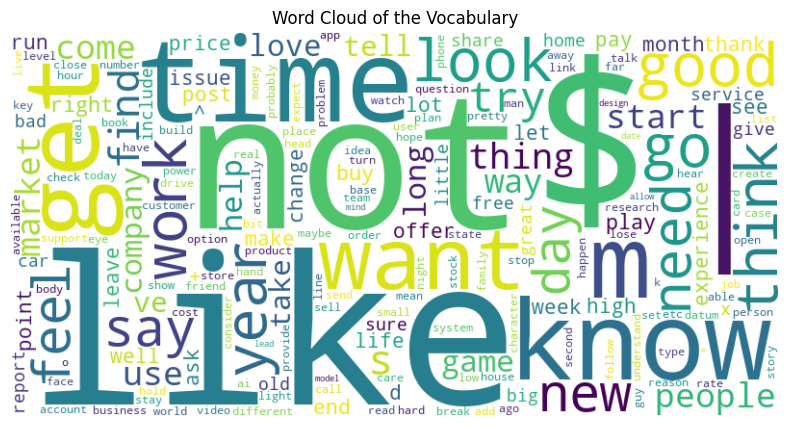

In [ ]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud of the Vocabulary")
plt.show()

## Topic Modeling The texts
Initially, we need to understand what sort of content we have. This will help deciding if we should go with data based topics or anchored topics.

In [25]:
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [ ]:
# topic_counts = range(2,30,2)

In [ ]:
# models = []
# c_v_coherence = []

# for i in tqdm(topic_counts):
#   # check if model is already in drive
#   model_path_temp = os.path.join(Models_path, "GensimLdaModel_SpacyTokens_TopicCount" + str(i))

#   if os.path.isfile(model_path_temp):
#     lda_model = LdaModel.load(model_path_temp)
#   else:
#     lda_model = LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=i,
#         random_state=random_seed,
#         passes=10,
#         iterations=50
#     )

#     # save the trained model
#     lda_model.save(model_path_temp)

#   # append the model to a list
#   models.append(lda_model)


#   cm = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
#   c_v_coherence.append(cm.get_coherence())

# metrics = pd.DataFrame({"Topic_Count": list(topic_counts), "c_v": c_v_coherence})
# metrics.head()

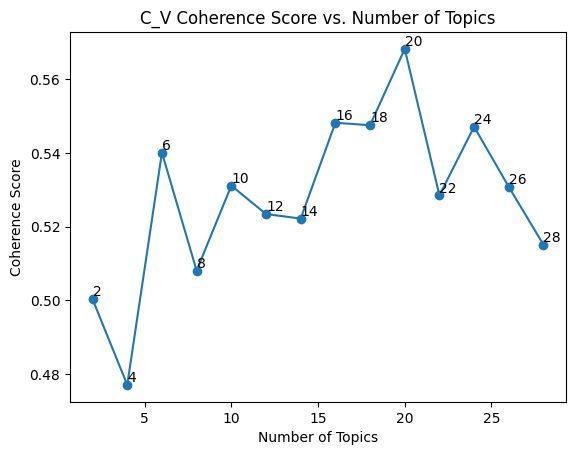

In [ ]:
# # plot coherence by the topic count
# import matplotlib.pyplot as plt

# plt.plot(metrics["Topic_Count"], metrics["c_v"], marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.title('C_V Coherence Score vs. Number of Topics')

# for i, txt in enumerate(metrics["Topic_Count"]):
#   plt.text(metrics["Topic_Count"][i], metrics["c_v"][i], f'{txt}', ha='left', va='bottom') # Format label to 2 decimal places


- 1: ranting probably
- 2: Intimate fiction
- 3: Personal growth
- 4: Jobs (Mostly tech jobs)
- 5: Financial Markets
- 6: Personal finance
- 7: Potentially daily stories and personal narratives?!
- 8: Health issues
- 9: Online stores - Purchases
- 10: Gaming
- 11: Computer technology (similar to 15)
- 12: Company news / Market news
- 13: Political news and posts
- 14: Streaming channels and relevant content (YT, Prime, ...)
- 15: Computer technology and gaming hardware
- 16: Books, Movies, Fiction, ...
- 17: Subreddit moderaters and banners in reddit
- 18: Company applications and policies
- 19: Gaming
- 20: Lifestyle

In [7]:
lda_model = ioFuncs.load_lda_model(Models_path)

if lda_model is None:
  # lda_model = LdaModel(
  #     corpus=corpus,
  #     id2word=dictionary,
  #     num_topics=20,
  #     random_state=random_seed,
  #     passes=10,
  #     iterations=50
  # )
  # # save the trained model
  # lda_model.save(model_path_temp)
  print("Trained model.")

pyLDAvis.enable_notebook()
# # top_model_index = metrics[metrics["Topic_Count"] == 20].index[0]
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=50)

b:\Projects\BehavioralPsychology\Fortune_company_opinion_mining\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.064568  0.384031       1        1  23.772013
13     0.202398  0.358173       2        1   9.723551
2     -0.102749  0.368151       3        1   8.384601
12    -0.222454  0.179049       4        1   6.704488
15    -0.339257  0.090155       5        1   6.277585
14    -0.269343  0.299665       6        1   5.144641
4      0.331210  0.253573       7        1   4.717422
18    -0.084917  0.050949       8        1   4.662751
0      0.013462  0.190928       9        1   4.450746
3      0.236556  0.104525      10        1   4.400016
5     -0.017400 -0.161242      11        1   3.112514
10    -0.340853 -0.162900      12        1   3.107484
19    -0.437882 -0.056785      13        1   2.794187
9      0.191995 -0.153315      14        1   2.540940
8      0.251966 -0.391136      15        1   2.517355
6      0.383724 -0.165035      16        1   2.473189
16     0.409296 -0.010511      17        1   2.093947
1      0.056555 -0.409985      18        1   1.274038
11    -0.230224 -0.337997      19        1   1.169010
17    -0.096651 -0.430293      20        1   0.679520, topic_info=         Term          Freq         Total Category  logprob  loglift
959         $  21016.000000  21016.000000  Default  50.0000  50.0000
3910        |  11402.000000  11402.000000  Default  49.0000  49.0000
659       not  15913.000000  15913.000000  Default  48.0000  48.0000
1837   market   5605.000000   5605.000000  Default  47.0000  47.0000
1134        +   3900.000000   3900.000000  Default  46.0000  46.0000
...       ...           ...           ...      ...      ...      ...
1124  walmart     63.832043    194.554832  Topic20  -5.5079   3.8771
298     limit     93.416148   1101.195371  Topic20  -5.1270   2.5245
505   vanilla     57.864487    141.125858  Topic20  -5.6060   4.1000
1233   credit     71.680722   1449.128465  Topic20  -5.3919   1.9850
2856     rare     55.449768    254.644744  Topic20  -5.6486   3.4671

[2214 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
959        5  0.198372        $
959       12  0.003378        $
959       15  0.798197        $
1134       4  0.006410        +
1134       5  0.002051        +
...      ...       ...      ...
3910      15  0.999895        |
4439      15  0.989836  |:-|:-|
12993     14  0.992403      |ye
12994     14  0.982011     |yes
2494      17  0.991421       ||

[5564 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 3, 13, 16, 15, 5, 19, 1, 4, 6, 11, 20, 10, 9, 7, 17, 2, 12, 18])

In [8]:
lda_model.get_topics().shape

(20, 103531)

In [11]:
temp_df.loc[50]["Text"]

'my players asked me about additional levels for the demi-humans. a few don\'t jive because they cannot get to level or do not like the idea of flip-flopping between classes. i was tinkering with the concept of demi-human occupational classes (think like "elf targetedcompany" that the player can pour xp to gain more levels (and scaling bonus hp) and also to get some extra unique elder dwarf/hobbit/elf skills that are ever present no matter the demi-human pc\'s current class. i was wondering if any of y\'all have done the same or have any thoughts on this addition'

In [ ]:
tokenized_texts[50]

['player',
 'ask',
 'additional',
 'level',
 'demi',
 'human',
 'jive',
 'level',
 'like',
 'idea',
 'flip',
 'flopping',
 'class',
 'tinker',
 'concept',
 'demi',
 'human',
 'occupational',
 'class',
 'think',
 'like',
 'elf',
 'player',
 'pour',
 'xp',
 'gain',
 'level',
 'scale',
 'bonus',
 'hp',
 'extra',
 'unique',
 'elder',
 'dwarf',
 'hobbit',
 'elf',
 'skill',
 'present',
 'matter',
 'demi',
 'human',
 'pc',
 'current',
 'class',
 'wonder',
 'you',
 'thought',
 'addition']

In [ ]:
corpus[50]

[(48, 1),
 (96, 1),
 (270, 1),
 (297, 2),
 (320, 1),
 (552, 3),
 (733, 1),
 (864, 1),
 (865, 1),
 (1008, 1),
 (1025, 1),
 (1110, 1),
 (1186, 1),
 (1187, 1),
 (1188, 1),
 (1189, 3),
 (1190, 1),
 (1191, 1),
 (1192, 2),
 (1193, 1),
 (1194, 1),
 (1195, 1),
 (1196, 1),
 (1197, 1),
 (1198, 3),
 (1199, 1),
 (1200, 3),
 (1201, 1),
 (1202, 1),
 (1203, 2),
 (1204, 1),
 (1205, 1),
 (1206, 1),
 (1207, 1),
 (1208, 1),
 (1209, 1),
 (1210, 1)]

In [ ]:
dictionary.doc2bow(tokenized_texts[50])

[(48, 1),
 (96, 1),
 (270, 1),
 (297, 2),
 (320, 1),
 (552, 3),
 (733, 1),
 (864, 1),
 (865, 1),
 (1008, 1),
 (1025, 1),
 (1110, 1),
 (1186, 1),
 (1187, 1),
 (1188, 1),
 (1189, 3),
 (1190, 1),
 (1191, 1),
 (1192, 2),
 (1193, 1),
 (1194, 1),
 (1195, 1),
 (1196, 1),
 (1197, 1),
 (1198, 3),
 (1199, 1),
 (1200, 3),
 (1201, 1),
 (1202, 1),
 (1203, 2),
 (1204, 1),
 (1205, 1),
 (1206, 1),
 (1207, 1),
 (1208, 1),
 (1209, 1),
 (1210, 1)]

In [16]:
len(tokenized_texts)

35192

In [26]:
doc_topics = pd.Series(lda_model.get_document_topics(corpus))
doc_topics

0        [(3, 0.10022924), (7, 0.5971279), (14, 0.22523...
1        [(1, 0.045905255), (7, 0.25298154), (15, 0.509...
2        [(7, 0.55386895), (18, 0.18218917), (19, 0.198...
3                        [(3, 0.36898464), (7, 0.5560016)]
4        [(0, 0.014509332), (2, 0.06326601), (3, 0.0222...
                               ...                        
35187    [(2, 0.24926054), (3, 0.13304247), (7, 0.36473...
35188                   [(1, 0.14998834), (7, 0.72141653)]
35189    [(1, 0.10923034), (3, 0.03868599), (4, 0.22995...
35190    [(1, 0.035617523), (2, 0.043610368), (3, 0.268...
35191    [(1, 0.50124377), (2, 0.25371578), (8, 0.17418...
Length: 35192, dtype: object

In [ ]:
topics = {
    1: "ranting probably",
    2: "Intimate fiction",
    3: "Personal growth",
    4: "Jobs (Mostly tech jobs)",
    5: "Financial Markets",
    6: "Personal finance",
    7: "Potentially daily stories and personal narratives?!",
    8: "Health issues",
    9: "Online stores - Purchases",
    10: "Gaming",
    11: "Computer technology (similar to 15)",
    12: "Company news / Market news",
    13: "Political news and posts",
    14: "Streaming channels and relevant content (YT, Prime, ...)",
    15: "Computer technology and gaming hardware",
    16: "Books, Movies, Fiction, ...",
    17: "Subreddit moderaters and banners in reddit",
    18: "Company applications and policies",
    19: "Gaming",
    20: "Lifestyle"
}

def select_topics(topic_list):
    threshold = 0.1
    topic_dic = {}
    for topic_id, topic_score in topic_list:
        topic_name = topics[topic_id + 1]

        if topic_score >= threshold:
            topic_dic[topic_name] = topic_score
    
    if len(topic_dic) == 0:
        return None
    
    return topic_dic


doc_topics.sample(10).apply(lambda x: select_topics(x))

25669    {'Health issues': 0.5770426, 'Gaming': 0.22135...
17614    {'Health issues': 0.6217838, 'Company news / M...
4878     {'Health issues': 0.21960923, 'Political news ...
32622    {'Personal growth': 0.19664723, 'Potentially d...
33149    {'Health issues': 0.4379301, 'Political news a...
20653    {'Health issues': 0.43119162, 'Gaming': 0.2024...
1723     {'Health issues': 0.662006, 'Gaming': 0.27796188}
23809    {'Potentially daily stories and personal narra...
1591     {'Health issues': 0.6334157, 'Gaming': 0.13667...
33572                            {'Lifestyle': 0.52496976}
dtype: object

In [32]:
temp_df

,Unnamed: 0,Company,Ticker,Sector,Industry,Text,Source
0,0,Walmart,WMT,Retailing,General Merchandisers,$googl $goog $targetedcompany google and targe...,Twitter
1,1,Walmart,WMT,Retailing,General Merchandisers,can $phnix become the first meme coin to dethr...,Twitter
2,2,Walmart,WMT,Retailing,General Merchandisers,targetedcompany $targetedcompany the laughing ...,Twitter
3,3,Walmart,WMT,Retailing,General Merchandisers,some of the most iconic businesses ever . $mcd...,Twitter
4,4,Walmart,WMT,Retailing,General Merchandisers,targetedcompany $targetedcompany currently has...,Twitter
...,...,...,...,...,...,...,...
345781,591336,Clear Channel Outdoor Hldgs.,CCO,Business Services,"Advertising, marketing",clear channel outdoor hldgs $targetedcompany m...,Twitter
345782,591337,Clear Channel Outdoor Hldgs.,CCO,Business Services,"Advertising, marketing",clear channel outdoor hldgs $targetedcompany s...,Twitter
345783,591338,Clear Channel Outdoor Hldgs.,CCO,Business Services,"Advertising, marketing",angelo gordon &amp; company lp maintains holdi...,Twitter
345784,591339,Clear Channel Outdoor Hldgs.,CCO,Business Services,"Advertising, marketing",clear channel outdoor hldgs $targetedcompany s...,Twitter


### Eval and vis

In [ ]:
# Map topic index to a descriptive title
topic_titles = {
    0: "Casual Online Chatter",
    1: "Book or Media Reviews",
    2: "Consumer Goods / Retail",
    3: "Finance & Business News",
    4: "Job Applications & Recruitment",
    5: "Tech Support & Software Use"
}


In [ ]:
# Count topics
topic_counts = temp_df["Topic"].value_counts().sort_index()

# Map the index to topic titles for labeling
labels = [topic_titles[i] for i in topic_counts.index]

# Plot with titles as x-axis labels
plt.figure(figsize=(10, 6))
plt.bar(labels, topic_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Document Counts per Topic")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

In [ ]:
# Group data by sector and topic, and count occurrences
sector_topic_counts = temp_df.groupby(['Sector', 'Topic'])['Topic'].count().unstack()

# Get sector and topic labels
sectors = sector_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each sector
bottom = [0] * len(sectors)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sectors, sector_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + sector_topic_counts[i][j] for j in range(len(sectors))]

# Set chart labels and formatting
ax.set_xlabel("Sector")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sectors")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
# Assuming your DataFrame is named 'temp_df' and contains 'Source' and 'Topic' columns

# Group data by source and topic, and count occurrences
source_topic_counts = temp_df.groupby(['Source', 'Topic'])['Topic'].count().unstack()

# Get source and topic labels
sources = source_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]  # Assuming you have topic_titles defined

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each source
bottom = [0] * len(sources)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sources, source_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + source_topic_counts[i][j] for j in range(len(sources))]

# Set chart labels and formatting
ax.set_xlabel("Source")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sources")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary to store the word clouds for each topic
topic_wordclouds = {}

# Iterate through each topic
for topic_index in range(lda.n_components):
    # Get documents belonging to the current topic
    topic_documents = temp_df[temp_df["Topic"] == topic_index]["Text"]

    # Create a frequency dictionary for words in the topic documents
    word_frequencies = {}
    for doc in topic_documents:
        for word in tokenize_text(doc):  # Use your tokenize_text function
            if word in feature_names:
                word_frequencies[word] = word_frequencies.get(word, 0) + 1

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

    # Store the word cloud in the dictionary
    topic_wordclouds[topic_index] = wordcloud

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_index}: {topic_titles[topic_index]}")  # Assuming you have topic_titles
    plt.show()
